In [ ]:
# This downloads the CIFAR-10 dataset if it doesn't already exist.

!wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz -O cifar-10-python.tar.gz
!tar -xzvf cifar-10-python.tar.gz
!rm cifar-10-python.tar.gz


--2023-02-28 14:19:32--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  13.0MB/s    in 17s     

2023-02-28 14:19:49 (9.55 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


# Utils

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
class Solver(object):

    def __init__(self, model, data, **kwargs):
       
        self.model = model
        self.X_train = data["X_train"]
        self.y_train = data["y_train"]
        self.X_val = data["X_val"]
        self.y_val = data["y_val"]

        # Unpack keyword arguments
        self.update_rule = kwargs.pop("update_rule", "sgd")
        self.optim_config = kwargs.pop("optim_config", {})
        self.lr_decay = kwargs.pop("lr_decay", 1.0)
        self.batch_size = kwargs.pop("batch_size", 100)
        self.num_epochs = kwargs.pop("num_epochs", 10)
        self.num_train_samples = kwargs.pop("num_train_samples", 1000)
        self.num_val_samples = kwargs.pop("num_val_samples", None)

        self.checkpoint_name = kwargs.pop("checkpoint_name", None)
        self.print_every = kwargs.pop("print_every", 10)
        self.verbose = kwargs.pop("verbose", True)

        # Throw an error if there are extra keyword arguments
        if len(kwargs) > 0:
            extra = ", ".join('"%s"' % k for k in list(kwargs.keys()))
            raise ValueError("Unrecognized arguments %s" % extra)

        if self.update_rule=='sgd':
            self.update_rule = sgd 
        elif self.update_rule=='sgd_momentum':
            self.update_rule = sgd_momentum
        elif self.update_rule=='rmsprop':
            self.update_rule = rmsprop
        elif self.update_rule=='adam':
            self.update_rule = adam

        self._reset()

    def _reset(self):
        # Set up some variables for book-keeping
        self.epoch = 0
        self.best_val_acc = 0
        self.best_params = {}
        self.loss_history = []
        self.train_acc_history = []
        self.test_acc_history = []
        self.val_acc_history = []

        # Make a deep copy of the optim_config for each parameter
        self.optim_configs = {}
        for p in self.model.params:
            d = {k: v for k, v in self.optim_config.items()}
            self.optim_configs[p] = d

    def _step(self):
        # Make a minibatch of training data
        num_train = self.X_train.shape[0]
        batch_mask = np.random.choice(num_train, self.batch_size)
        X_batch = self.X_train[batch_mask]
        y_batch = self.y_train[batch_mask]

        # Compute loss and gradient
        loss, grads = self.model.loss(X_batch, y_batch)
        self.loss_history.append(loss)

        # Perform a parameter update
        for p, w in self.model.params.items():
            dw = grads[p]
            config = self.optim_configs[p]
            next_w, next_config = self.update_rule(w, dw, config)
            self.model.params[p] = next_w
            self.optim_configs[p] = next_config

    def _step1(self):
        # Make a minibatch of training data
        num_test = self.X_test.shape[0]
        batch_mask = np.random.choice(num_test, self.batch_size)
        X_batch1 = self.X_test[batch_mask]
        y_batch1 = self.y_test[batch_mask]

        # Compute loss and gradient
        loss, grads = self.model.loss(X_batch1, y_batch1)
        self.loss_history.append(loss)

        # Perform a parameter update
        for p, w in self.model.params.items():
            dw = grads[p]
            config = self.optim_configs[p]
            next_w, next_config = self.update_rule(w, dw, config)
            self.model.params[p] = next_w
            self.optim_configs[p] = next_config

    def _save_checkpoint(self):
        if self.checkpoint_name is None:
            return
        checkpoint = {
            "model": self.model,
            "update_rule": "sgd",
            "lr_decay": self.lr_decay,
            "optim_config": self.optim_config,
            "batch_size": self.batch_size,
            "num_test_samples": self.num_test_samples,
            "num_val_samples": self.num_val_samples,
            "epoch": self.epoch,
            "loss_history": self.loss_history,
            "test_acc_history": self.test_acc_history,
            "val_acc_history": self.val_acc_history,
        }
        filename = "%s_epoch_%d.pkl" % (self.checkpoint_name, self.epoch)
        if self.verbose:
            print('Saving checkpoint to "%s"' % filename)
        with open(filename, "wb") as f:
            pickle.dump(checkpoint, f)

    def check_accuracy(self, X, y, num_samples=None, batch_size=100):
        # Maybe subsample the data
        N = X.shape[0]
        if num_samples is not None and N > num_samples:
            mask = np.random.choice(N, num_samples)
            N = num_samples
            X = X[mask]
            y = y[mask]

        # Compute predictions in batches
        num_batches = N // batch_size
        if N % batch_size != 0:
            num_batches += 1
        y_pred = []
        for i in range(num_batches):
            start = i * batch_size
            end = (i + 1) * batch_size
            scores = self.model.loss(X[start:end])
            y_pred.append(np.argmax(scores, axis=1))
        y_pred = np.hstack(y_pred)
        conf_mt = confusion_matrix(y,y_pred)
        acc = np.mean(y_pred == y)
        print(conf_mt)
        return acc
    
    def train(self):
        """
      Run optimization to train the model.
        """
        num_train = self.X_train.shape[0]
        iterations_per_epoch = max(num_train // self.batch_size, 1)
        num_iterations = self.num_epochs * iterations_per_epoch

        for t in range(num_iterations):
            self._step()

            # Maybe print training loss
            if self.verbose and t % self.print_every == 0:
                print(
                    "(Iteration %d / %d) loss: %f"
                    % (t + 1, num_iterations, self.loss_history[-1])
                )

            # At the end of every epoch, increment the epoch counter and decay
            # the learning rate.
            epoch_end = (t + 1) % iterations_per_epoch == 0
            if epoch_end:
                self.epoch += 1
                for k in self.optim_configs:
                    self.optim_configs[k]["learning_rate"] *= self.lr_decay

            # Check train and val accuracy on the first iteration, the last
            # iteration, and at the end of each epoch.
            first_it = t == 0
            last_it = t == num_iterations - 1
            if first_it or last_it or epoch_end:
                train_acc = self.check_accuracy(
                    self.X_train, self.y_train, num_samples=self.num_train_samples
                )
                val_acc = self.check_accuracy(
                    self.X_val, self.y_val, num_samples=self.num_val_samples
                )
                self.train_acc_history.append(train_acc)
                self.val_acc_history.append(val_acc)
                self._save_checkpoint()

                if self.verbose:
                    print(
                        "(Epoch %d / %d) train acc: %f; val_acc: %f"
                        % (self.epoch, self.num_epochs, train_acc, val_acc)
                    )

                # Keep track of the best model
                if val_acc > self.best_val_acc:
                    self.best_val_acc = val_acc
                    self.best_params = {}
                    for k, v in self.model.params.items():
                        self.best_params[k] = v.copy()

        # At the end of training swap the best params into the model
        self.model.params = self.best_params

    

In [ ]:
#@title Data utils

from __future__ import print_function

from builtins import range
from six.moves import cPickle as pickle
import numpy as np
import os
from imageio import imread
import platform


def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == "2":
        return pickle.load(f)
    elif version[0] == "3":
        return pickle.load(f, encoding="latin1")
    raise ValueError("invalid python version: {}".format(version))


def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, "rb") as f:
        datadict = load_pickle(f)
        X = datadict["data"]
        Y = datadict["labels"]
        X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("float")
        Y = np.array(Y)
        return X, Y


def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1, 6):
        f = os.path.join(ROOT, "data_batch_%d" % (b,))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, "test_batch"))
    return Xtr, Ytr, Xte, Yte


def get_CIFAR10_data(
    num_training=49000, num_validation=1000, num_test=1000, subtract_mean=True
):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for classifiers. These are the same steps as we used for the SVM, but
    condensed to a single function.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = "cifar-10-batches-py"
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    if subtract_mean:
        mean_image = np.mean(X_train, axis=0)
        X_train -= mean_image
        X_val -= mean_image
        X_test -= mean_image

    # Transpose so that channels come first
    X_train = X_train.transpose(0, 3, 1, 2).copy()
    X_val = X_val.transpose(0, 3, 1, 2).copy()
    X_test = X_test.transpose(0, 3, 1, 2).copy()

    # Package data into a dictionary
    return {
        "X_train": X_train,
        "y_train": y_train,
        "X_val": X_val,
        "y_val": y_val,
        "X_test": X_test,
        "y_test": y_test,
    }

# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in list(data.items()):
  print(('%s: ' % k, v.shape))

('X_train: ', (49000, 3, 32, 32))
('y_train: ', (49000,))
('X_val: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))


### Test function

In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 1.13.1+cu116
torchvision version: 0.14.1+cu116


In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3435, done.
remote: Total 3435 (delta 0), reused 0 (delta 0), pack-reused 3435
Receiving objects: 100% (3435/3435), 641.56 MiB | 30.28 MiB/s, done.
Resolving deltas: 100% (1975/1975), done.
Updating files: 100% (222/222), done.


In [ ]:
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

### Code

In [ ]:

def sgd(w, dw, config=None):
    if config is None:
        config = {}
    config.setdefault("learning_rate", 1e-2)
    w -= config['learning_rate'] * dw
    return w, config


def sgd_momentum(w, dw, config=None):
    if config is None:
        config = {}
    config.setdefault("learning_rate", 1e-2)
    config.setdefault("momentum", 0.9)
    v = config.get("velocity", np.zeros_like(w))
    next_w = None
    v = config['momentum'] * v - config['learning_rate'] * dw 
    next_w = w + v                                            
    config["velocity"] = v

    return next_w, config

In [ ]:
#@title Forward/Backward utils
from builtins import range
import numpy as np


def linear_forward(x, w, b):

    out = None

    num_examples = x.shape[0]

    flattend_x = x.reshape((num_examples, -1))
    out = flattend_x @ w + b

    cache = (x, w, b)
    return out, cache


def linear_backward(dout, cache):
    x, w, b = cache
    dx, dw, db = None, None, None
    num_examples = x.shape[0]
    flattend_x = x.reshape((num_examples, -1))
    dw = flattend_x.T @ dout
    db = np.ones(num_examples) @ dout
    dx = dout @ w.T
    dx = dx.reshape(x.shape)
    return dx, dw, db


def relu_forward(x):
    out = np.where(x > 0, x, 0)
    cache = x
    return out, cache


def relu_backward(dout, cache):
    dx, x = None, cache
    mask = (x > 0).astype(int)  # (N,...)
    dx = dout * mask
    return dx


def softmax_loss(x, y):
    loss, dx = None, None
    logits = x - np.max(x, axis=1, keepdims=True)
    exp = np.exp(logits)
    probs = exp / np.sum(exp, axis=1, keepdims=True)
    loss = -np.log(probs[range(len(y)), y])
    loss = np.mean(loss)
    probs[range(len(y)), y] -= 1
    dx = probs / len(y)
    return loss, dx

def linear_relu_forward(x, w, b):
    a, fc_cache = linear_forward(x, w, b)
    out, relu_cache = relu_forward(a)
    cache = (fc_cache, relu_cache)
    return out, cache

def linear_relu_backward(dout, cache):
    fc_cache, relu_cache = cache
    da = relu_backward(dout, relu_cache)
    dx, dw, db = linear_backward(da, fc_cache)
    return dx, dw, db

def linear_relu_dropout_forward(x, w, b, dropout_param):
    a, fc_cache = linear_forward(x, w, b)
    out, relu_cache = relu_forward(a)
    out, dropout_cache = dropout_forward(out, dropout_param)
    cache = (fc_cache, relu_cache, dropout_cache)
    return out, cache

def linear_relu_dropout_backward(dout, cache):
    fc_cache, relu_cache, dropout_cache = cache
    dout = dropout_backward(dout, dropout_cache)
    da = relu_backward(dout, relu_cache)
    dx, dw, db = linear_backward(da, fc_cache)
    return dx, dw, db

def dropout_forward(x, dropout_param):
    p, mode = dropout_param["p"], dropout_param["mode"]
    if "seed" in dropout_param:
        np.random.seed(dropout_param["seed"])

    mask = None
    out = None

    if mode == "train":
        N, D = x.shape
        mask = np.random.uniform(0, 1, D)
        mask = np.where(mask < p, 1, 0.)
        out = x * mask / p
    elif mode == "test":
        out = x
    cache = (dropout_param, mask)
    out = out.astype(x.dtype, copy=False)

    return out, cache

def dropout_backward(dout, cache):

    dropout_param, mask = cache
    mode = dropout_param["mode"]

    dx = None
    if mode == "train":
      dx = dout * mask / dropout_param["p"]
    elif mode == "test":
        dx = dout
    return dx

In [ ]:
#@title Numerical gradient check utils
def eval_numerical_gradient_array(f, x, df, h=1e-5):
    """
    Evaluate a numeric gradient for a function that accepts a numpy
    array and returns a numpy array.
    """
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=["multi_index"], op_flags=["readwrite"])
    while not it.finished:
        ix = it.multi_index

        oldval = x[ix]
        x[ix] = oldval + h
        pos = f(x).copy()
        x[ix] = oldval - h
        neg = f(x).copy()
        x[ix] = oldval

        grad[ix] = np.sum((pos - neg) * df) / (2 * h)
        it.iternext()
    return grad

def eval_numerical_gradient(f, x, verbose=True, h=0.00001):
    """
    a naive implementation of numerical gradient of f at x
    - f should be a function that takes a single argument
    - x is the point (numpy array) to evaluate the gradient at
    """

    fx = f(x)  # evaluate function value at original point
    grad = np.zeros_like(x)
    # iterate over all indexes in x
    it = np.nditer(x, flags=["multi_index"], op_flags=["readwrite"])
    while not it.finished:

        # evaluate function at x+h
        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h  # increment by h
        fxph = f(x)  # evalute f(x + h)
        x[ix] = oldval - h
        fxmh = f(x)  # evaluate f(x - h)
        x[ix] = oldval  # restore

        # compute the partial derivative with centered formula
        grad[ix] = (fxph - fxmh) / (2 * h)  # the slope
        if verbose:
            print(ix, grad[ix])
        it.iternext()  # step to next dimension

    return grad

In [ ]:
# Setup cell.
import time
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # Set default size of plots.
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

%load_ext autoreload
%autoreload 2

def print_mean_std(x,axis=0):
    print(f"  means: {x.mean(axis=axis)}")
    print(f"  stds:  {x.std(axis=axis)}\n")
    
def rel_error(x, y):
    """Returns relative error."""
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [ ]:
class FullyConnectedNet(object):
    def __init__(
        self,
        hidden_dims,
        input_dim=3 * 32 * 32,
        num_classes=10,
        dropout_keep_ratio=1,
        normalization=None,
        reg=0.0,
        weight_scale=1e-2,
        dtype=np.float32,
        seed=None,
    ):
        self.normalization = normalization
        self.use_dropout = dropout_keep_ratio != 1
        self.reg = reg
        self.num_layers = 1 + len(hidden_dims)
        self.dtype = dtype
        self.params = {}

        szs = [input_dim] + hidden_dims + [num_classes]
        for i in range(self.num_layers):
            self.params[f"W{i+1}"] = np.random.normal(0., weight_scale, size=(szs[i], szs[i+1]))
            self.params[f"b{i+1}"] = np.zeros(szs[i+1])


        # When using dropout we need to pass a dropout_param dictionary to each
        # dropout layer so that the layer knows the dropout probability and the mode
        # (train / test). You can pass the same dropout_param to each dropout layer.
        self.dropout_param = {}
        if self.use_dropout:
            self.dropout_param = {"mode": "train", "p": dropout_keep_ratio}
            if seed is not None:
                self.dropout_param["seed"] = seed


    def loss(self, X, y=None):
        X = X.astype(self.dtype)
        mode = "test" if y is None else "train"

        # Set train/test mode for batchnorm params and dropout param since they
        # behave differently during training and testing.
        if self.use_dropout:
            self.dropout_param["mode"] = mode
        scores = None
        cache = {}
        X = X.reshape(X.shape[0], -1)
        for i in range(1, self.num_layers):
            if self.use_dropout:
                X, cache[i] = linear_relu_dropout_forward(X, self.params[f'W{i}'], self.params[f'b{i}'], self.dropout_param)
            else:
                X, cache[i] = linear_relu_forward(X, self.params[f'W{i}'], self.params[f'b{i}'])
        scores, cache[self.num_layers] = \
            linear_forward(X, self.params[f'W{self.num_layers}'], self.params[f'b{self.num_layers}'])

        # If test mode return early.
        if mode == "test":
            return scores

        loss, grads = 0.0, {}

        loss, dout = softmax_loss(scores, y)
        loss += 0.5 * self.reg * sum([np.sum(w * w) for name, w in self.params.items() if 'W' in name])

        dout, grads[f'W{self.num_layers}'], grads[f'b{self.num_layers}'] \
            = linear_backward(dout, cache[self.num_layers])
        grads[f'W{self.num_layers}'] += self.reg * self.params[f'W{self.num_layers}']

        for i in range(self.num_layers-1, 0, -1):
            if self.use_dropout:
                dout, grads[f'W{i}'], grads[f'b{i}'] = linear_relu_dropout_backward(dout, cache[i])
            else:
                dout, grads[f'W{i}'], grads[f'b{i}'] = linear_relu_backward(dout, cache[i])

            grads[f'W{i}'] += self.reg * self.params[f'W{i}']
        return loss, grads

#Optimization 

In [ ]:
def rmsprop(w, dw, config=None):
    
    if config is None:
        config = {}
    config.setdefault("learning_rate", 1e-2)
    config.setdefault("decay_rate", 0.99)
    config.setdefault("epsilon", 1e-8)
    config.setdefault("cache", np.zeros_like(w))

    next_w = None
   
    rho = config["decay_rate"]
    lr = config["learning_rate"]
    eps = config["epsilon"]
    config["cache"] *= rho
    config["cache"] += (1.0 - rho) * dw ** 2
    step = -(lr * dw) / (np.sqrt(config["cache"]) + eps)
    w += step
    next_w = w

    
    return next_w, config


In [ ]:
# Test RMSProp implementation

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  9.524687511038133e-08
cache error:  2.6477955807156126e-09


In [ ]:
def adam(w, dw, config=None):
    
    if config is None:
        config = {}
    config.setdefault("learning_rate", 1e-3)
    config.setdefault("beta1", 0.9)
    config.setdefault("beta2", 0.999)
    config.setdefault("epsilon", 1e-8)
    config.setdefault("m", np.zeros_like(w))
    config.setdefault("v", np.zeros_like(w))
    config.setdefault("t", 0)

    next_w = None
    

    beta1, beta2, eps = config["beta1"], config["beta2"], config["epsilon"]
    t, m, v = config["t"], config["m"], config["v"]
    m = beta1 * m + (1 - beta1) * dw
    v = beta2 * v + (1 - beta2) * (dw * dw)
    t += 1
    alpha = config["learning_rate"] * np.sqrt(1 - beta2 ** t) / (1 - beta1 ** t)
    w -= alpha * (m / (np.sqrt(v) + eps))
    config["t"] = t
    config["m"] = m
    config["v"] = v
    next_w = w

    return next_w, config


In [ ]:
# Test Adam implementation

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])


print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

next_w error:  1.1355763428905147e-07
v error:  4.208314038113071e-09
m error:  4.214963193114416e-09


#1 hidden layer

In [ ]:
num_train = 49000
small_data = {
  "X_train": data["X_train"][:num_train],
  "y_train": data["y_train"][:num_train],
  "X_val": data["X_val"],
  "y_val": data["y_val"],
}

solvers = {}
model = FullyConnectedNet(
        [500]
    )

solver = Solver(
        model,
        small_data,
        num_epochs=25,
        batch_size=100,
        update_rule='adam',
        optim_config={'learning_rate': 5e-4,},
        verbose=True,
        print_every=100
    )
solver.train()
print()

(Iteration 1 / 12250) loss: 8.625939
[[28 24  0  1  0  0  1 10 18 17]
 [ 8 11  1  2  0  1  1 34  5 34]
 [21 19  0  3  1  0  1 46  4  9]
 [13 15  1  6  3  3  2 42  3 13]
 [ 6  8  1  5  3  0  1 60  5  5]
 [12 14  2  4  0  1  4 41  3  4]
 [ 9 15  1  2  2  3  1 64  3  4]
 [19 18  2  5  1  4  1 35  4 11]
 [10 13  0  3  0  0  3 11 45 25]
 [ 7  7  2  4  1  1  4 17  8 55]]
[[15 21  0  1  1  0  0 12 25 12]
 [ 7 16  0  4  1  1  4 36 12 38]
 [ 9 12  0  3  4  0  1 38  7  5]
 [18 19  1 16  0  1  1 40  3 13]
 [ 7  6  2  3  2  0  1 49  7  1]
 [16 14  0 10  0  2  7 43  2  4]
 [10 11  1  1  2  1  3 64  2  7]
 [12 19  4  7  2  2  1 38  3 19]
 [ 7 10  0  5  0  0  2  9 48 32]
 [10 15  1  3  1  0  0 18 14 43]]
(Epoch 0 / 25) train acc: 0.185000; val_acc: 0.183000
(Iteration 101 / 12250) loss: 4.931085
(Iteration 201 / 12250) loss: 2.646918
(Iteration 301 / 12250) loss: 1.708921
(Iteration 401 / 12250) loss: 1.710476
[[39  9  3  0  7  5  0  8 16  9]
 [ 3 55  2  0  2  1  0  3 13 15]
 [ 7  4 51  7 13 26  1  6

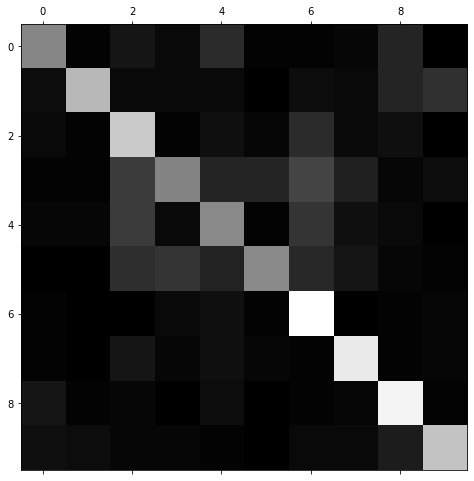

In [ ]:
cf_matix_train = np.array([[43 , 1,  7,  3, 14,  1,  1,  2, 12,  0],
 [ 4, 59,  3,  3,  3,  0,  4,  3, 12, 16],
 [ 3,  1, 65,  1,  5,  2, 14,  3,  5,  0],
 [ 1,  1, 19, 42, 12, 12, 22, 10,  2,  4],
 [ 2,  2, 19,  3, 44,  1, 17,  5,  3,  0],
 [ 0,  0, 15, 17, 11, 44, 13,  7,  2,  1],
 [ 1,  0,  0,  3,  5,  1, 82,  0,  1,  2],
 [ 1,  0,  7,  2,  5,  2,  1, 75,  1,  2],
 [ 7,  1,  2,  0,  4,  0,  1,  2, 78,  1],
 [ 5,  4,  2,  2,  1,  0,  3,  3,  9, 63]])
plt.matshow(cf_matix_train,cmap=plt.cm.gray
            )#plot the matrix
plt.show()

In [ ]:
# Load the testing data
test_data = {
    "X_test": data["X_test"],
    "y_test": data["y_test"],
}

# Use the trained model to make predictions on the testing data
scores = model.loss(test_data["X_test"])
y_pred = np.argmax(scores, axis=1)

# Compute the accuracy of the predictions
accuracy = np.mean(y_pred == test_data["y_test"])
print("Test accuracy:", accuracy)

Test accuracy: 0.474


#5 hidden layers

Running with  sgd
(Iteration 1 / 2450) loss: 2.739870
[[12  9 11 26  1 30  1  0  0 13]
 [23 20 15 11  2 13  2  3  0 10]
 [18 17 13 12  2 21  1  2  0 14]
 [11 19 12 11  1 12  2  3  0 22]
 [13 16 11 16  1 23  3  0  0 20]
 [21 24  9 12  0  8  5  0  0 25]
 [15 11 15  9  1 19  4  0  1 17]
 [12 16 15 19  0 30  0  1  0 17]
 [ 8 11  9 17  0 20  2  0  0 21]
 [19 26  9 19  0 18  2  2  0 13]]
[[12 12 10 14  0 28  2  0  0  9]
 [25 33 13 21  1 14  2  0  1  9]
 [14 13  9  7  0 17  0  1  0 18]
 [22 19 13 15  0 23  3  0  0 17]
 [15 13 15  5  0 12  4  1  0 13]
 [20 23 11 13  0 11  3  1  0 16]
 [22 17  8 12  4 17  0  1  0 21]
 [10 16 16 10  1 21  6  1  1 25]
 [17 14  9 13  1 25  4  1  0 29]
 [14 18 19 19  0 14  3  0  0 18]]
(Epoch 0 / 5) train acc: 0.083000; val_acc: 0.099000
(Iteration 11 / 2450) loss: 2.302497
(Iteration 21 / 2450) loss: 2.146861
(Iteration 31 / 2450) loss: 2.166362
(Iteration 41 / 2450) loss: 2.251302
(Iteration 51 / 2450) loss: 2.117274
(Iteration 61 / 2450) loss: 2.065367
(Iteratio

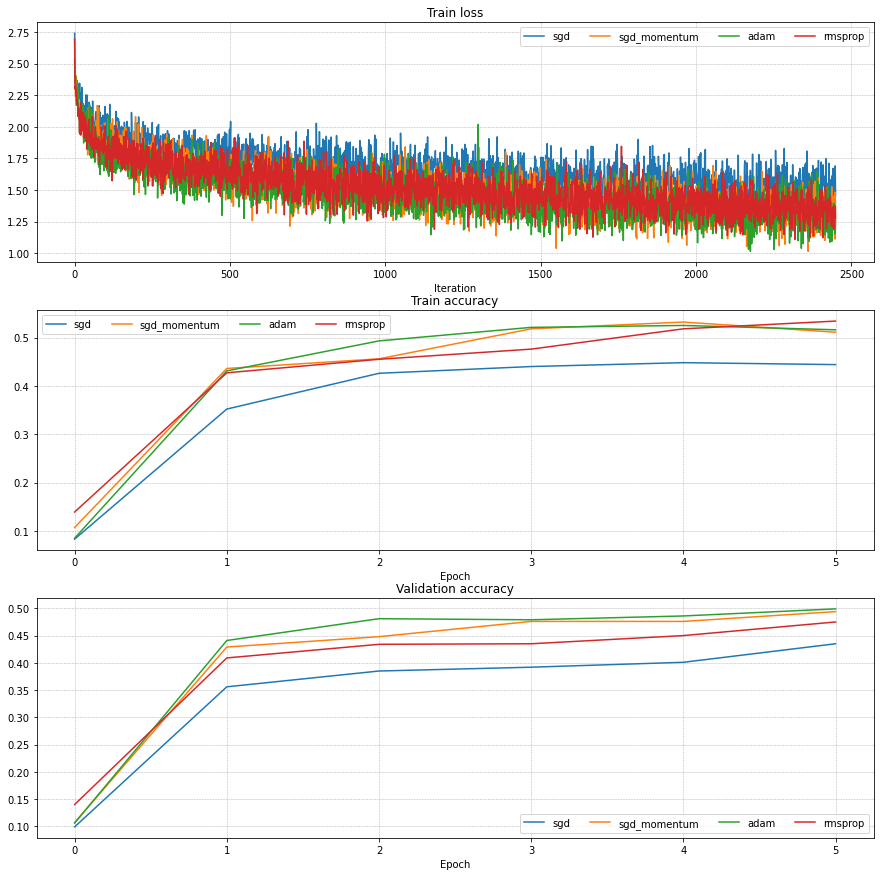

In [ ]:
num_train = 49000
small_data = {
  "X_train": data["X_train"][:num_train],
  "y_train": data["y_train"][:num_train],
  "X_val": data["X_val"],
  "y_val": data["y_val"],
}

solvers = {}

learning_rates = {'sgd': 5e-3, 'sgd_momentum': 5e-3, 'rmsprop': 1e-4, 'adam': 1e-3}
for update_rule in ['sgd', 'sgd_momentum', 'adam', 'rmsprop']:
    print('Running with ', update_rule)
    model = FullyConnectedNet(
        [100, 100, 100, 100, 100],
        weight_scale=5e-2
    )
    solver = Solver(
        model,
        small_data,
        num_epochs=5,
        batch_size=100,
        update_rule=update_rule,
        optim_config={'learning_rate': learning_rates[update_rule]},
        verbose=True
    )
    solvers[update_rule] = solver
    solver.train()
    print()
    
fig, axes = plt.subplots(3, 1, figsize=(15, 15))

axes[0].set_title('Train loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Train accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')

for update_rule, solver in solvers.items():
    axes[0].plot(solver.loss_history, label=f"{update_rule}")
    axes[1].plot(solver.train_acc_history, label=f"{update_rule}")
    axes[2].plot(solver.val_acc_history, label=f"{update_rule}")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

In [ ]:
test_accs = {}
for update_rule, solver in solvers.items():
    test_acc = solver.check_accuracy(data['X_test'], data['y_test'])
    test_accs[update_rule] = test_acc
    print(f"Test accuracy for {update_rule}: {test_acc:.4f}")

best_solver = solvers[max(test_accs, key=test_accs.get)]
y_test_pred = model.params



[[49  1  8  0  3  2  8  5 21  6]
 [ 3 53  3  1  1  0  6  3  4 15]
 [11  6 33  8 11  6 16  4  4  1]
 [ 4  6  9 12  6 20 27  6  5  8]
 [ 9  2 15  4 20  5 19  5  5  6]
 [ 1  4  9 10  8 24 14  8  5  3]
 [ 2  4  9  5 15  8 62  2  1  4]
 [ 3  4 10 11  7  6  6 45  3  7]
 [10  4  3  1  1  3  2  1 73  8]
 [ 5 21  5  2  1  1  4  3 10 57]]
Test accuracy for sgd: 0.4280
[[48  3  4  3  3  1  7  1 18 15]
 [ 3 47  0  2  1  0  4  2  9 21]
 [11  3 30 14 13  8  9  4  3  5]
 [ 2  2 12 45  5  9 14  2  4  8]
 [ 8  1 10  8 33  4 13  9  1  3]
 [ 1  1  8 26  9 20  5  8  1  7]
 [ 0  3  7 16 15  1 61  2  3  4]
 [ 5  1  6  8  9  6  0 53  1 13]
 [12  1  2  3  2  1  0  1 74 10]
 [ 2 12  0  3  1  0  0  5  9 77]]
Test accuracy for sgd_momentum: 0.4880
[[39  4 15  2 10  4  3  2 19  5]
 [ 0 67  1  1  1  0  2  3  6  8]
 [ 5  2 47  7 10  6 12  6  1  4]
 [ 1  3 15 26  5 24 13  2  2 12]
 [ 4  4 10  5 30  7 15 12  1  2]
 [ 0  1 12 14  7 30 10  7  4  1]
 [ 1  1 11  9  8  5 68  5  2  2]
 [ 3  3  4 10  7 10  3 55  2  5]
 [10 